# Simple CNN for PETALO

Esta red la vamos a utilizar para obtener el radio 

In [1]:
import numpy as np
#np.random.seed(1337)  # for reproducibility
from time import time
from datetime import datetime
from sklearn import preprocessing
import sys

sys.path.append("/home/rgadea/lmfit-py/")
sys.path.append("/home/rgadea/experimentos/viherbos/")

print(sys.path)
import json 

import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

# import seaborn as sns
from keras.datasets import mnist
from keras.models import Model, Sequential, load_model
from keras.layers import Input, Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D,Conv3D, MaxPooling3D, MaxPooling2D,BatchNormalization
from keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils
from keras import regularizers
from keras.optimizers import Adam, Nadam, RMSprop, SGD
from math import floor
from lmfit.models import  GaussianModel
import matplotlib.pyplot as plt

['/home/rgadea/anaconda3/envs/tensorflow3/lib/python36.zip', '/home/rgadea/anaconda3/envs/tensorflow3/lib/python3.6', '/home/rgadea/anaconda3/envs/tensorflow3/lib/python3.6/lib-dynload', '', '/home/rgadea/anaconda3/envs/tensorflow3/lib/python3.6/site-packages', '/home/rgadea/anaconda3/envs/tensorflow3/lib/python3.6/site-packages/IPython/extensions', '/volumedisk0/home/rgadea/.ipython', '/home/rgadea/lmfit-py/', '/home/rgadea/experimentos/viherbos/']


Using TensorFlow backend.
/home/rgadea/anaconda3/envs/tensorflow3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/rgadea/anaconda3/envs/tensorflow3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/rgadea/anaconda3/envs/tensorflow3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home

In [2]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()
import tensorflow as tf
print(tf.__version__)
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

1.13.1


## Vamos introducir los datos de petalo preprocesados en pyhton


In [3]:
filtro=2
if filtro==1:
    npzfile = np.load('../conjuntos_datos_nuevos_2020/02_06_2020_sfilt3_5m.npz')
    npzfile.files
    conjunto_datos_entradasA=npzfile['arr_0']
    conjunto_datos_entradasB=npzfile['arr_1']
    conjunto_datos_salidas=npzfile['arr_2']
    string_filter='sin_filtro'
else:
    if filtro==2:
        npzfile = np.load('../conjuntos_datos_nuevos_2020/02_06_2020_filt3_5m.npz')
        npzfile.files
        conjunto_datos_entradasA=npzfile['arr_0']
#         conjunto_datos_entradasC=npzfile['arr_4']
        conjunto_datos_entradasB=npzfile['arr_1']       
        conjunto_datos_salidas=npzfile['arr_2']
        string_filter='con_filtro_AE'        
    else:
        npzfile = np.load('../conjuntos_datos_nuevos_2020/11_12_2019.npz')
        npzfile.files
        entradas_sensorsA1=npzfile['arr_0']
        entradas_sensorsB1=npzfile['arr_1']
        coordenadas1=npzfile['arr_2']
        entradas_sensorsA2=npzfile['arr_3']
        entradas_sensorsB2=npzfile['arr_4']
        coordenadas2=npzfile['arr_5']
        conjunto_datos_entradasA=np.concatenate((entradas_sensorsA1,entradas_sensorsA2),axis=0)
        conjunto_datos_entradasB=np.concatenate((entradas_sensorsB1,entradas_sensorsB2),axis=0)
        conjunto_datos_salidas=np.concatenate((coordenadas1,coordenadas2),axis=0)


print('conjunto_datos_entradas A shape:', conjunto_datos_entradasA.shape)
print('conjunto_datos_entradas B shape:', conjunto_datos_entradasB.shape)
print('conjunto_datos_salidas shape:', conjunto_datos_salidas.shape)

conjunto_datos_entradas A shape: (3809, 20, 175)
conjunto_datos_entradas B shape: (3809, 20, 175)
conjunto_datos_salidas shape: (3809, 3)


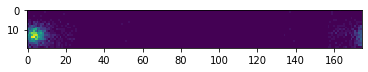

[ -3.0052954  169.114081    25.08075523]


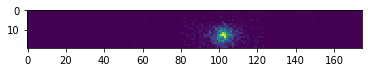

[  0.52486554 169.08637408  26.15795708]


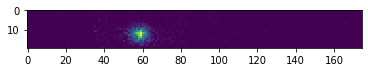

[ -1.02810868 173.48978989  21.30581856]


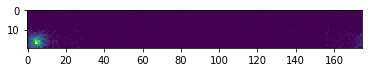

[ -2.96264907 173.36569858  48.9164505 ]


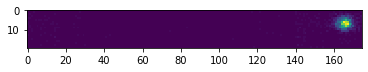

[  2.80762676 176.22079442 -19.7967205 ]


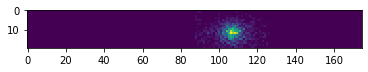

[  0.69990422 166.2739038   15.07876778]


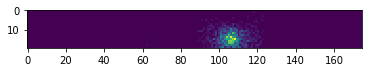

[  0.67542045 165.14368492  39.96489716]


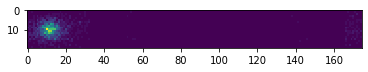

[ -2.7229417  168.42406807   4.57291842]


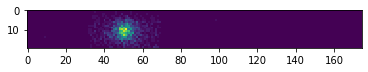

[ -1.32396437 165.78876588  11.01046848]


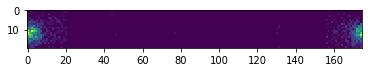

[ -3.11144809 167.37767758  16.57446098]


In [4]:
for i in range(1,11):
    idea=np.random.randint(1,conjunto_datos_entradasB.shape[0])
    plt.imshow(conjunto_datos_entradasB[idea], cmap='viridis')
    plt.show()
    print(conjunto_datos_salidas[idea,0:3])

## Network parameters:

In [5]:

batch_size = 250
nb_classes = 10
nb_epoch = 400

# input image dimensions
img_rows, img_cols = 20, 43
# number of convolutional filters to use
nb_filters = 32
# size of pooling area for max pooling
pool_size = (2, 2)
# convolution kernel size
kernel_size = ( 4, 4)

## Prepare data into training and test set.

In [6]:
muestras=conjunto_datos_entradasA.shape[0]
# veamos=idea.reshape(idea.shape[0],175, 20)


veamos2A=np.zeros([muestras,20,175])
veamos2_3A=np.zeros([muestras,20,525])
veamos2B=np.zeros([muestras,20,175])
veamos2_3B=np.zeros([muestras,20,525])
sector2A=np.zeros([muestras,20,img_cols])
sector2B=np.zeros([muestras,20,img_cols])
veamos3=np.zeros([muestras,175])
# for i in range(idea.shape[0]):
for i in range(muestras):
    veamos2A[i]=conjunto_datos_entradasA[i]
    veamos2B[i]=conjunto_datos_entradasB[i]
    veamos3[i]=np.sum(veamos2A[i], axis=0)
    indice=np.argmax(veamos3[i], axis=0)
    indice_inferior=int(indice-((img_cols-1)/2)+175)
    indice_superior=int(indice+((img_cols+1)/2)+175)
    veamos2_3A[i]=np.concatenate((veamos2A[i],veamos2A[i],veamos2A[i]),axis=1) 
    veamos2_3B[i]=np.concatenate((veamos2B[i],veamos2B[i],veamos2B[i]),axis=1) 
    sector2A[i]=veamos2_3A[i,:,indice_inferior:indice_superior]
    sector2B[i]=veamos2_3B[i,:,indice_inferior:indice_superior]      

## data augmentation mediante flip horizontal y vertical

Atencion: la z es copiada pero en realidad es incorrecta. Podemos asegurar que el radio y phi si que son las mismas; pero la z claramente al hacer un flip vertical no puede ser la misma

In [7]:
veamosA=np.zeros([4*muestras,20,img_cols])
veamosB=np.zeros([4*muestras,20,img_cols])
conjunto_datos_salidas_nuevo=np.zeros([4*muestras,3])
for i in range(muestras):
    veamosA[i*4]=sector2A[i]  
    caramba=np.flipud(sector2A[i]) 
    veamosA[i*4+1]=caramba  
    veamosA[i*4+2]=np.fliplr(caramba)     
    veamosA[i*4+3]=np.fliplr(sector2A[i])     
    veamosB[i*4]=sector2B[i]   
    caramba=np.flipud(sector2B[i]) 
    veamosB[i*4+1]=caramba   
    veamosB[i*4+2]=np.fliplr(caramba)  
    veamosB[i*4+3]=np.fliplr(sector2B[i])
    conjunto_datos_salidas_nuevo[i*4]=conjunto_datos_salidas[i]
    conjunto_datos_salidas_nuevo[i*4+1]=conjunto_datos_salidas[i]    
    conjunto_datos_salidas_nuevo[i*4+2]=conjunto_datos_salidas[i]  
    conjunto_datos_salidas_nuevo[i*4+3]=conjunto_datos_salidas[i]  

In [8]:
print('sector A shape:', veamosA.shape)
conjunto_datos_nuevoA=veamosA.reshape(veamosA.shape[0], img_rows*img_cols)
print('conjunto_datos_nuevo A:', conjunto_datos_nuevoA.shape)

print('sector B shape:', veamosB.shape)
conjunto_datos_nuevoB=veamosB.reshape(veamosB.shape[0], img_rows*img_cols)
print('conjunto_datos_nuevo B:', conjunto_datos_nuevoB.shape)
print('conjunto_datos_salidas_nuevo:', conjunto_datos_salidas_nuevo.shape)

sector A shape: (15236, 20, 43)
conjunto_datos_nuevo A: (15236, 860)
sector B shape: (15236, 20, 43)
conjunto_datos_nuevo B: (15236, 860)
conjunto_datos_salidas_nuevo: (15236, 3)


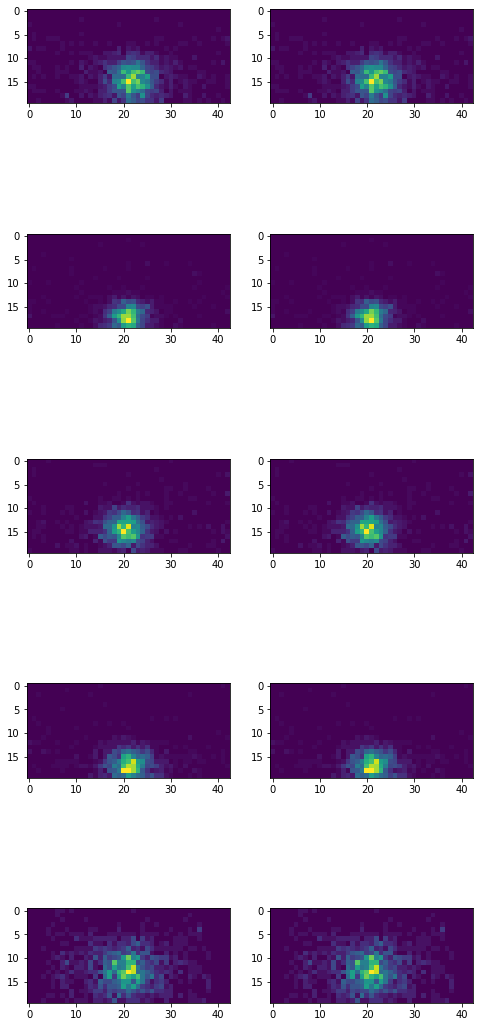

In [9]:
n = 5  # how many digits we will display

fig = plt.figure(figsize=(8,20))

for i in range(n):
    # display original
    ideas=np.random.randint(1,muestras)
    ax = fig.add_subplot(n, 2, (i)*2+1)
    plt.imshow(sector2A[ideas], cmap='viridis')
    plt.viridis()

    # display reconstruction
    ax = fig.add_subplot(n, 2, (i)*2+2)
    plt.imshow(sector2B[ideas], cmap='viridis')
    plt.viridis()

plt.show()

# print(x_test[idea])
# print(decoded_imgs[idea])
# print(decoded_imgs_scaled[idea])


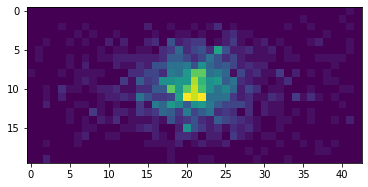

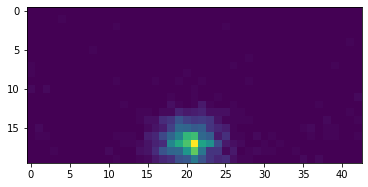

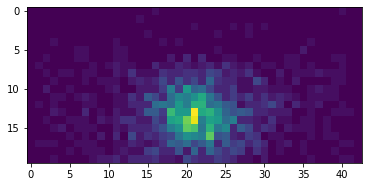

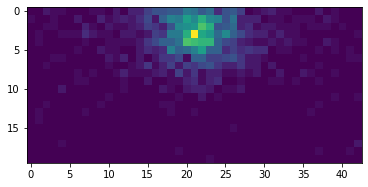

In [10]:
# convert class vectors to binary class matrices
#Y_train = np_utils.to_categorical(y_train, nb_classes)
#Y_test = np_utils.to_categorical(y_test, nb_classes)
for i in range(1,5):
    idea=np.random.randint(1,sector2B.shape[0])
    plt.imshow(sector2B[idea], cmap='viridis')
    plt.show()

In [11]:
numero_muestras=4*muestras
tr_size=60
val_size=20
test_size=100-val_size-tr_size
conjunto_datos_nuevo2=np.concatenate((conjunto_datos_salidas_nuevo,conjunto_datos_nuevoB), axis=1)

tamanyo_tr=floor(tr_size*numero_muestras/100)
tamanyo_val=floor(val_size*numero_muestras/100)
tamanyo_test=numero_muestras-tamanyo_tr-tamanyo_val
print(tamanyo_tr)
print(tamanyo_val)
print(tamanyo_test)


XY_test=conjunto_datos_nuevo2[tamanyo_tr+tamanyo_val:numero_muestras,:]


XY_test_bin0=XY_test[np.where((XY_test[:,1]>=164.9999) * (XY_test[:,1]<171.000))]
XY_test_bin1=XY_test[np.where((XY_test[:,1]>=171.000) * (XY_test[:,1]<177.000))]
XY_test_bin2=XY_test[np.where((XY_test[:,1]>=177.000) * (XY_test[:,1]<183.0000))]
XY_test_bin3=XY_test[np.where((XY_test[:,1]>=183.000) * (XY_test[:,1]<189.0000))]
XY_test_bin4=XY_test[np.where((XY_test[:,1]>=189.0000))]

X_train=conjunto_datos_nuevo2[:tamanyo_tr,3:]
X_val=conjunto_datos_nuevo2[tamanyo_tr:tamanyo_tr+tamanyo_val,3:]
X_test=conjunto_datos_nuevo2[tamanyo_tr+tamanyo_val:numero_muestras,3:]









X_test_bin0=XY_test_bin0[:,3:]
Y_test_bin0=XY_test_bin0[:,1]
print(X_test_bin0.shape)
X_test_bin1=XY_test_bin1[:,3:]
Y_test_bin1=XY_test_bin1[:,1]
print(X_test_bin1.shape)
X_test_bin2=XY_test_bin2[:,3:]
Y_test_bin2=XY_test_bin2[:,1]
print(X_test_bin2.shape)
X_test_bin3=XY_test_bin3[:,3:]
Y_test_bin3=XY_test_bin3[:,1]
print(X_test_bin3.shape)
X_test_bin4=XY_test_bin4[:,3:]
Y_test_bin4=XY_test_bin4[:,1]
print(X_test_bin4.shape)

Y_train=conjunto_datos_nuevo2[:tamanyo_tr,1] #elijo la coordenada radius que en matlab esta en la 1
Y_val=conjunto_datos_nuevo2[tamanyo_tr:tamanyo_tr+tamanyo_val,1] #elijo la corrdenada radius
Y_test=conjunto_datos_nuevo2[tamanyo_tr+tamanyo_val:numero_muestras,1] #elijo la corrdenada radius

9141
3047
3048
(1992, 860)
(856, 860)
(132, 860)
(64, 860)
(4, 860)


Vamos a normalizar las salidas por si luego nos interea

In [12]:
Y_total=conjunto_datos_nuevo2[:numero_muestras,0]
min_max_scaler = preprocessing.MinMaxScaler().fit(Y_total.reshape(-1, 1))

Y_train_scaled = min_max_scaler.transform(Y_train.reshape(-1, 1))
Y_val_scaled = min_max_scaler.transform(Y_val.reshape(-1, 1))
Y_test_scaled = min_max_scaler.transform(Y_test.reshape(-1, 1))

# Y_test_bin4_scaled=min_max_scaler.transform(Y_test_bin4.reshape(-1, 1))
Y_test_bin3_scaled=min_max_scaler.transform(Y_test_bin3.reshape(-1, 1))
Y_test_bin2_scaled=min_max_scaler.transform(Y_test_bin2.reshape(-1, 1))
Y_test_bin1_scaled=min_max_scaler.transform(Y_test_bin1.reshape(-1, 1))
Y_test_bin0_scaled=min_max_scaler.transform(Y_test_bin0.reshape(-1, 1))

In [13]:


X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols,1)
X_val = X_val.reshape(X_val.shape[0], img_rows, img_cols,1)
X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols,1)

X_test_bin0 = X_test_bin0.reshape(X_test_bin0.shape[0],  img_rows, img_cols,1)
X_test_bin1 = X_test_bin1.reshape(X_test_bin1.shape[0],  img_rows, img_cols,1)
X_test_bin2 = X_test_bin2.reshape(X_test_bin2.shape[0],  img_rows, img_cols,1)
X_test_bin3 = X_test_bin3.reshape(X_test_bin3.shape[0],  img_rows, img_cols,1)
X_test_bin4 = X_test_bin4.reshape(X_test_bin4.shape[0],  img_rows, img_cols,1)

input_shape = ( img_rows, img_cols,1)
#input_shape=input_shape.astype('int32')

In [14]:
X_train = X_train.astype('float32')
X_val= X_val.astype('float32')
X_test = X_test.astype('float32')

print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_val.shape[0], 'validation samples')
print(X_test.shape[0], 'test samples')

X_train shape: (9141, 20, 43, 1)
9141 train samples
3047 validation samples
3048 test samples


## Data augmentation

In [15]:
datagen = ImageDataGenerator(horizontal_flip=True,
                            vertical_flip=True)

In [16]:

# kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01))

In [17]:
use_regularizer = True
my_regularizer = None
# my_epochs = 50
# hidden_size=320
features_path = 'simple_autoe_features.pickle'
labels_path = 'simple_autoe_labels.pickle'

if use_regularizer:
    # add a sparsity constraint on the encoded representations
    # note use of 10e-5 leads to blurred results
    my_regularizer = regularizers.l1(0.00001)
    # and a larger number of epochs as the added regularization the model
    # is less likely to overfit and can be trained longer
    my_epochs = 100
    features_path = 'sparse_autoe_features.pickle'
    labels_path = 'sparse_autoe_labels.pickle'
import keras.backend as KK
import keras.callbacks as KKcall

class Metrics(KKcall.Callback):
    def on_train_begin(self, logs={}):
        self._data = []

    def on_epoch_end(self, batch, logs={}):
        X_val, y_val = self.validation_data[0], self.validation_data[1]
        y_predict = np.asarray(self.model.predict(X_val))

#         y_val = np.sum((y_val+1)*supermax/2, axis=1)
#         y_predict = np.sum((y_predict+1)*supermax/2, axis=1)

        self._data.append({
            'val_energy': np.std(y_predict-y_val),
        })
        return

    def get_data(self):
        return self._data

metrics = Metrics()
def  sigma (y_true, y_pred):
    return KK.std(y_true-y_pred)



## Build the CNN. 

In [18]:
model = Sequential()

model.add(Conv2D(16, kernel_size=kernel_size,
                        padding='same',
                        activity_regularizer=my_regularizer,
                        data_format='channels_last',
                        input_shape=(img_rows,img_cols,1)))
model.add(BatchNormalization(momentum=0.6))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=pool_size))

model.add(Conv2D(16, kernel_size,  kernel_regularizer=my_regularizer, padding='same'))
model.add(BatchNormalization(momentum=0.6))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=pool_size))

model.add(Conv2D(32, kernel_size,  kernel_regularizer=my_regularizer, padding='same'))
model.add(BatchNormalization(momentum=0.6))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=pool_size))

model.add(Conv2D(32, kernel_size,  kernel_regularizer=my_regularizer, padding='same'))

model.add(Activation('relu'))
model.add(BatchNormalization(momentum=0.6))

model.add(Conv2D(64, kernel_size, kernel_regularizer=my_regularizer, padding='same'))

model.add(Activation('relu'))
model.add(BatchNormalization(momentum=0.6))

model.add(Conv2D(64, kernel_size, kernel_regularizer=my_regularizer, padding='same'))

model.add(Activation('relu'))
model.add(BatchNormalization(momentum=0.6))

model.add(Conv2D(128, kernel_size,kernel_regularizer=my_regularizer, padding='same'))

model.add(Activation('relu'))
model.add(BatchNormalization(momentum=0.6))

model.add(Dropout(0.2))
model.add(Flatten())
# model.add(Dense(10))
# model.add(Activation('tanh'))
model.add(Dense(1,use_bias=True, 
                kernel_regularizer=my_regularizer             
               ))


dt = datetime.now().replace(second=0, microsecond=0)
experimento="CNN_kernel_{}x{}_soloB_{}_input_dimension_{}x{}x{}_elu".format(kernel_size[0],kernel_size[1],string_filter,img_rows,img_cols,1)
algoritmo='Nadam'
optimizador=Nadam(beta_1=0.9, beta_2=0.999)

tensorboard=TensorBoard(log_dir="../logs/defs/2020/{}{}{}".format(experimento,algoritmo,dt))
best_model_name='../redes_CNN_R/models_best/CNN_regression_R_{}_{}_{}_{}_{}.h5'.format(nb_epoch,batch_size,experimento,algoritmo,dt)
model_check=ModelCheckpoint(best_model_name, monitor='val_sigma', verbose=1, save_best_only=True, save_weights_only=False, mode='min', period=1)
early_stop=EarlyStopping(monitor='val_loss', min_delta=0, patience=900, verbose=1, mode='auto', baseline=None)
model.compile(loss='mean_squared_error',
              optimizer=optimizador,
             metrics=[sigma])



Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Show a summary of the model parameters. 

In [19]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 20, 43, 16)        272       
_________________________________________________________________
batch_normalization_1 (Batch (None, 20, 43, 16)        64        
_________________________________________________________________
activation_1 (Activation)    (None, 20, 43, 16)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 10, 21, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 21, 16)        4112      
_________________________________________________________________
batch_normalization_2 (Batch (None, 10, 21, 16)        64        
_________________________________________________________________
activation_2 (Activation)    (None, 10, 21, 16)        0         
__________

And now train the model and evaluate on the test set. 

In [20]:
history = model.fit(X_train, Y_train, batch_size=batch_size, epochs=nb_epoch,
          verbose=1, validation_data=(X_val, Y_val),
                     callbacks=[tensorboard,model_check,early_stop])

Instructions for updating:
Use tf.cast instead.
Train on 9141 samples, validate on 3047 samples
Epoch 1/400
9141/9141 [==============================] - 4s 397us/step - loss: 10226.0961 - sigma: 3.4523 - val_loss: 2382.5825 - val_sigma: 2.4808

Epoch 00001: val_sigma improved from inf to 2.48081, saving model to ../redes_CNN_R/models_best/CNN_regression_R_400_250_CNN_kernel_4x4_soloB_con_filtro_AE_input_dimension_20x43x1_elu_Nadam_2020-06-02 16:25:00.h5
Epoch 2/400
9141/9141 [==============================] - 1s 86us/step - loss: 743.4329 - sigma: 3.0743 - val_loss: 57.0983 - val_sigma: 1.7892

Epoch 00002: val_sigma improved from 2.48081 to 1.78919, saving model to ../redes_CNN_R/models_best/CNN_regression_R_400_250_CNN_kernel_4x4_soloB_con_filtro_AE_input_dimension_20x43x1_elu_Nadam_2020-06-02 16:25:00.h5
Epoch 3/400
9141/9141 [==============================] - 1s 88us/step - loss: 23.2685 - sigma: 3.1424 - val_loss: 12.3708 - val_sigma: 1.3080

Epoch 00003: val_sigma improved from 1

In [21]:
dt = datetime.now().replace(second=0, microsecond=0)
model.save_weights('../redes_CNN_R/defs/CNN_regression_R_{}_{}_{}_{}_{}'.format(nb_epoch,batch_size,experimento,algoritmo,dt))

In [22]:

#best_model_guardado='../redes_CNN_R/models_best/CNN_regression_R_1000_500_CNN_kernel_4x4_soloB_sin_filtro_input_dimension_20x41x1_elu_Nadam_2020-02-17 09:34:00.h5'
best_model = load_model(best_model_name, custom_objects={'sigma':sigma})
# best_model = model
score = best_model.evaluate(X_test, Y_test, verbose=0)
print('Test mse:', score)
# print('Test mae:', score[1])
Y_test_predicted=best_model.predict(X_test)
print(Y_test_predicted[:10].flatten())
print(Y_test[:10])
from sklearn.metrics import mean_squared_error
mse=mean_squared_error(Y_test, Y_test_predicted)

print('Test2 mse:', mse)
error_prediction=Y_test-Y_test_predicted.flatten()
print(error_prediction[:10])

Test mse: [0.7341467088914606, 0.46363614464369346]
[174.95543 175.14081 174.68974 174.86679 168.20992 168.27946 168.28441
 168.44977 166.47075 166.65889]
[175.56629    175.56629    175.56629    175.56629    169.21858193
 169.21858193 169.21858193 169.21858193 166.76943387 166.76943387]
Test2 mse: 0.5912102215038096
[0.61086092 0.42548189 0.87654696 0.69949923 1.00866677 0.93911721
 0.93417336 0.76881387 0.29868496 0.11054409]


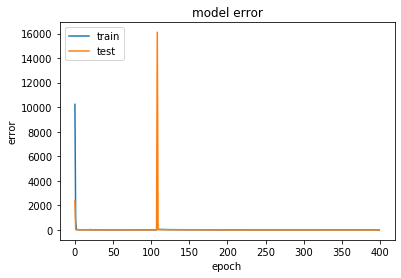

In [23]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model error')
plt.ylabel('error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [24]:
#print(error_prediction)

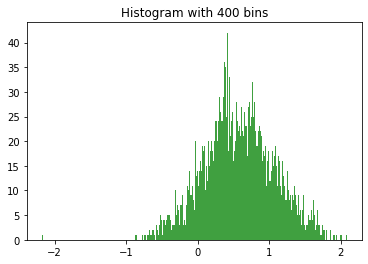

(400,)
(401,)
[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 34
    # data points      = 400
    # variables        = 3
    chi-square         = 3229.75579
    reduced chi-square = 8.13540502
    Akaike info crit   = 841.478904
    Bayesian info crit = 853.453298
[[Variables]]
    amp:  25.7635614 +/- 0.38236368 (1.48%) (init = 1000)
    cen:  0.56497197 +/- 0.00858360 (1.52%) (init = 0)
    wid:  0.70842394 +/- 0.01214910 (1.71%) (init = 1)
[[Correlations]] (unreported correlations are < 0.100)
    C(amp, wid) = -0.578



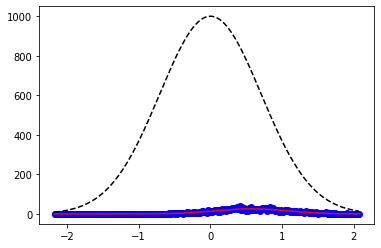

In [25]:

n, bins, patches = plt.hist(error_prediction, 400, density=0, facecolor='green', alpha=0.75)
plt.title("Histogram with 400 bins")
plt.show()
x=bins[:400]
y=n
print(n.shape)
print(bins.shape)
from numpy import exp, loadtxt, pi, sqrt, log

from lmfit import Model
def gaussian(x, amp, cen, wid):
    """1-d gaussian: gaussian(x, amp, cen, wid)"""
    return amp * exp(-((x-cen)/wid)**2 )






gmodel = Model(gaussian)
result = gmodel.fit(y, x=x, amp=1000, cen=0, wid=1)

print(result.fit_report())

plt.plot(x, y, 'bo')
plt.plot(x, result.init_fit, 'k--')
plt.plot(x, result.best_fit, 'r-')
plt.show()





In [26]:
FWHM=result.params['wid'].value*2*sqrt(log(2))

In [27]:
print(FWHM)

1.1796032308620552


[[Model]]
    Model(lorentzian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 29
    # data points      = 400
    # variables        = 3
    chi-square         = 4394.23600
    reduced chi-square = 11.0686045
    Akaike info crit   = 964.633766
    Bayesian info crit = 976.608159
[[Variables]]
    sigma:      0.48144977 +/- 0.01410939 (2.93%) (init = 0.4412427)
    center:     0.55600532 +/- 0.00970352 (1.75%) (init = 0.5581543)
    amplitude:  41.9267578 +/- 0.86683858 (2.07%) (init = 69.49573)
    fwhm:       0.96289953 +/- 0.02821878 (2.93%) == '2.0000000*sigma'
    height:     27.7198225 +/- 0.56137239 (2.03%) == '0.3183099*amplitude/max(1.e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.250)
    C(sigma, amplitude) =  0.723



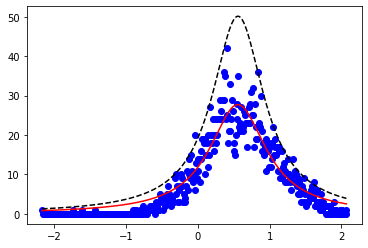

In [28]:
from lmfit.models import LorentzianModel
mod = LorentzianModel()
x=bins[:400]
y=n
pars = mod.guess(y, x=x)
out = mod.fit(y, pars, x=x)

print(out.fit_report(min_correl=0.25))
FWHM=out.params['fwhm'].value

plt.plot(x, y, 'bo')
plt.plot(x, out.init_fit, 'k--')
plt.plot(x, out.best_fit, 'r-')
plt.show()

In [29]:
print(FWHM)

0.9628995342609703


[[168.20992]
 [168.27946]
 [168.28441]
 ...
 [167.92224]
 [168.17143]
 [168.0752 ]]
[[Model]]
    Model(lorentzian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 29
    # data points      = 400
    # variables        = 3
    chi-square         = 2528.94789
    reduced chi-square = 6.37014583
    Akaike info crit   = 743.637638
    Bayesian info crit = 755.612032
[[Variables]]
    sigma:      0.44319764 +/- 0.01450837 (3.27%) (init = 0.3615001)
    center:     0.49881339 +/- 0.01004624 (2.01%) (init = 0.4855505)
    amplitude:  27.1210924 +/- 0.62660293 (2.31%) (init = 44.73563)
    fwhm:       0.88639529 +/- 0.02901674 (3.27%) == '2.0000000*sigma'
    height:     19.4786960 +/- 0.44322519 (2.28%) == '0.3183099*amplitude/max(1.e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.250)
    C(sigma, amplitude) =  0.719

0.8863952889961424


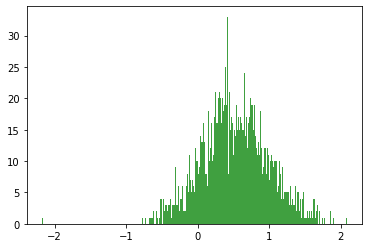

In [30]:
Y_test_bin0_predicted=best_model.predict(X_test_bin0)
print(Y_test_bin0_predicted)
error_prediction_bin0=Y_test_bin0-Y_test_bin0_predicted.flatten()
n, bins, patches = plt.hist(error_prediction_bin0, 400, density=0, facecolor='green', alpha=0.75)

x=bins[:400]
y=n

gmodel = Model(gaussian)
result = gmodel.fit(y, x=x, amp=1000, cen=0, wid=1)
FWHM_bin0=result.params['wid'].value*2*sqrt(log(2))
pars = mod.guess(y, x=x)
out = mod.fit(y, pars, x=x)

print(out.fit_report(min_correl=0.25))
FWHM_bin0=out.params['fwhm'].value

print(FWHM_bin0)

[[Model]]
    Model(lorentzian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 21
    # data points      = 400
    # variables        = 3
    chi-square         = 931.141325
    reduced chi-square = 2.34544414
    Akaike info crit   = 343.978607
    Bayesian info crit = 355.953001
[[Variables]]
    sigma:      0.56612445 +/- 0.03636389 (6.42%) (init = 0.5610487)
    center:     0.77081382 +/- 0.02361124 (3.06%) (init = 0.7368931)
    amplitude:  8.37651140 +/- 0.37883482 (4.52%) (init = 21.03933)
    fwhm:       1.13224890 +/- 0.07272778 (6.42%) == '2.0000000*sigma'
    height:     4.70978863 +/- 0.19865100 (4.22%) == '0.3183099*amplitude/max(1.e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.250)
    C(sigma, amplitude) =  0.756

1.1322489032101153


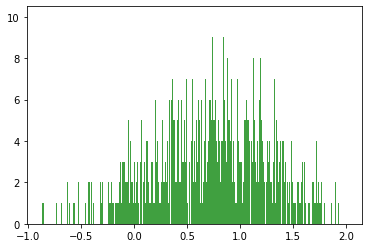

In [31]:
Y_test_bin1_predicted=best_model.predict(X_test_bin1)
#print(Y_test_bin1_predicted)
error_prediction_bin1=Y_test_bin1-Y_test_bin1_predicted.flatten()
n, bins, patches = plt.hist(error_prediction_bin1, 400, density=0, facecolor='green', alpha=0.75)

x=bins[:400]
y=n

gmodel = Model(gaussian)
result = gmodel.fit(y, x=x, amp=1000, cen=0, wid=1)
FWHM_bin1=result.params['wid'].value*2*sqrt(log(2))

pars = mod.guess(y, x=x)
out = mod.fit(y, pars, x=x)

print(out.fit_report(min_correl=0.25))
FWHM_bin1=out.params['fwhm'].value

print(FWHM_bin1)

[[Model]]
    Model(lorentzian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 29
    # data points      = 400
    # variables        = 3
    chi-square         = 114.281590
    reduced chi-square = 0.28786295
    Akaike info crit   = -495.119624
    Bayesian info crit = -483.145231
[[Variables]]
    sigma:      0.31686418 +/- 0.04479199 (14.14%) (init = 0.5545873)
    center:     0.46377688 +/- 0.03052791 (6.58%) (init = 0.5367975)
    amplitude:  0.82937989 +/- 0.08264523 (9.96%) (init = 6.239107)
    fwhm:       0.63372835 +/- 0.08958398 (14.14%) == '2.0000000*sigma'
    height:     0.83316401 +/- 0.08078679 (9.70%) == '0.3183099*amplitude/max(1.e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.250)
    C(sigma, amplitude) =  0.728

0.6337283522646211


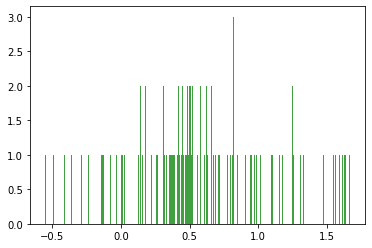

In [32]:
Y_test_bin2_predicted=best_model.predict(X_test_bin2)
#print(Y_test_bin2_predicted)
error_prediction_bin2=Y_test_bin2-Y_test_bin2_predicted.flatten()
n, bins, patches = plt.hist(error_prediction_bin2, 400, density=0, facecolor='green', alpha=0.75)

x=bins[:400]
y=n

gmodel = Model(gaussian)
result = gmodel.fit(y, x=x, amp=1000, cen=0, wid=1)
FWHM_bin2=result.params['wid'].value*2*sqrt(log(2))

pars = mod.guess(y, x=x)
out = mod.fit(y, pars, x=x)

print(out.fit_report(min_correl=0.25))
FWHM_bin2=out.params['fwhm'].value


print(FWHM_bin2)

[[Model]]
    Model(lorentzian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 400
    # variables        = 3
    chi-square         = 58.5120896
    reduced chi-square = 0.14738562
    Akaike info crit   = -762.892461
    Bayesian info crit = -750.918068
[[Variables]]
    sigma:      0.43511461 +/- 0.10438031 (23.99%) (init = 0.2716254)
    center:     0.55721889 +/- 0.06442251 (11.56%) (init = 0.5978616)
    amplitude:  0.41752525 +/- 0.07068612 (16.93%) (init = 2.03719)
    fwhm:       0.87022922 +/- 0.20876062 (23.99%) == '2.0000000*sigma'
    height:     0.30544233 +/- 0.04566932 (14.95%) == '0.3183099*amplitude/max(1.e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.250)
    C(sigma, amplitude) =  0.786

0.8702292217204262


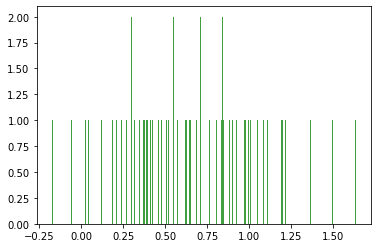

In [33]:
Y_test_bin3_predicted=best_model.predict(X_test_bin3)
#print(Y_test_bin3_predicted)
error_prediction_bin3=Y_test_bin3-Y_test_bin3_predicted.flatten()
n, bins, patches = plt.hist(error_prediction_bin3, 400, density=0, facecolor='green', alpha=0.75)

x=bins[:400]
y=n

gmodel = Model(gaussian)
result = gmodel.fit(y, x=x, amp=1000, cen=0, wid=1)
FWHM_bin3=result.params['wid'].value*2*sqrt(log(2))

pars = mod.guess(y, x=x)
out = mod.fit(y, pars, x=x)

print(out.fit_report(min_correl=0.25))
FWHM_bin3=out.params['fwhm'].value


print(FWHM_bin3)

[[Model]]
    Model(lorentzian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 193
    # data points      = 400
    # variables        = 3
    chi-square         = 2.99999883
    reduced chi-square = 0.00755667
    Akaike info crit   = -1951.14106
    Bayesian info crit = -1939.16667
[[Variables]]
    sigma:      1.8000e-05 +/- 1.68976299 (9387368.42%) (init = 0.4509115)
    center:    -0.46660163 +/- 0.28408038 (60.88%) (init = -0.08394782)
    amplitude:  0.00230855 +/- 218.595978 (9468974.26%) (init = 1.690918)
    fwhm:       3.6001e-05 +/- 3.37952598 (9387368.43%) == '2.0000000*sigma'
    height:     40.8232378 +/- 7697769.47 (18856342.32%) == '0.3183099*amplitude/max(1.e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.250)
    C(sigma, amplitude)  = -1.000
    C(center, amplitude) = -1.000
    C(sigma, center)     =  1.000

3.600078132937057e-05
0.8702292217204262
0.6337283522646211
1.1322489032101153
0.8863952889961424


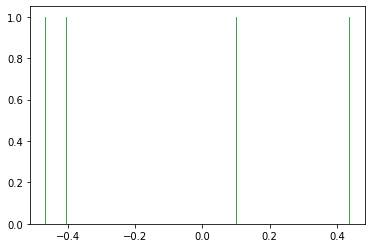

In [34]:
Y_test_bin4_predicted=best_model.predict(X_test_bin4)
#print(Y_test_bin4_predicted)
error_prediction_bin4=Y_test_bin4-Y_test_bin4_predicted.flatten()
n, bins, patches = plt.hist(error_prediction_bin4, 400, density=0, facecolor='green', alpha=0.75)

x=bins[:400]
y=n

gmodel = Model(gaussian)
result = gmodel.fit(y, x=x, amp=1000, cen=0, wid=1)
FWHM_bin4=result.params['wid'].value*2*sqrt(log(2))

pars = mod.guess(y, x=x)
out = mod.fit(y, pars, x=x)

print(out.fit_report(min_correl=0.25))
FWHM_bin4=out.params['fwhm'].value

print(FWHM_bin4)
print(FWHM_bin3)
print(FWHM_bin2)
print(FWHM_bin1)
print(FWHM_bin0)

Veamos ahora los histogramnas 2d que nos interesan